# Chapter 4: Fundamentals of Rock Properties (Averaging)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In reservoir engineering, properties like **Permeability ($k$)** and **Porosity ($\phi$)** vary significantly with depth. To perform calculations (or run simulations), we often need to represent a heterogeneous layered reservoir as a single homogeneous block.

In this notebook, we will:
1.  **Generate Synthetic Core Data:** Simulate a reservoir with multiple layers of varying thickness and properties.
2.  **Calculate Average Permeability:** Implement the three major averaging methods (**Arithmetic**, **Harmonic**, and **Geometric**) and understand when to use which.
3.  **Calculate Average Porosity:** Compute the thickness-weighted average porosity.

## 1. The Scenario

Imagine we have a well that penetrates **5 distinct layers** of a reservoir. We have taken core samples from each layer and measured their properties in the lab.

| Layer | Thickness ($h_i$) | Permeability ($k_i$) | Porosity ($\phi_i$) |
| :--- | :--- | :--- | :--- |
| 1 | 10 ft | 50 md | 18% |
| 2 | 15 ft | 250 md | 22% |
| 3 | 5 ft | 10 md | 12% |
| 4 | 20 ft | 100 md | 19% |
| 5 | 10 ft | 800 md | 25% |

We need to calculate the single equivalent permeability and porosity for this entire zone.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# --- 1. DEFINE CORE DATA ---
data = {
    'Layer': [1, 2, 3, 4, 5],
    'Thickness_h': [10, 15, 5, 20, 10],   # ft
    'Permeability_k': [50, 250, 10, 100, 800], # md
    'Porosity_phi': [0.18, 0.22, 0.12, 0.19, 0.25] # fraction
}

df = pd.DataFrame(data)

# Calculate Total Thickness
h_total = df['Thickness_h'].sum()

print(f"--- Core Analysis Data (Total Thickness: {h_total} ft) ---")
print(df)

--- Core Analysis Data (Total Thickness: 60 ft) ---
   Layer  Thickness_h  Permeability_k  Porosity_phi
0      1           10              50          0.18
1      2           15             250          0.22
2      3            5              10          0.12
3      4           20             100          0.19
4      5           10             800          0.25


## 2. Average Permeability ($\bar{k}$)

Permeability is a vector property (direction matters). The correct averaging method depends on the **direction of flow** relative to the bedding planes.

### A. Arithmetic Average (Parallel Flow)
Used when flow is **parallel** to the layers (e.g., flow into a vertical wellbore from a layered reservoir). It is dominated by high-permeability layers.

$$\bar{k}_{arith} = \frac{\sum_{i=1}^{n} k_i h_i}{\sum_{i=1}^{n} h_i}$$

### B. Harmonic Average (Series Flow)
Used when flow is **perpendicular** to the layers (e.g., vertical flow into a horizontal well, or flow crossing a fault). It is dominated by low-permeability (tight) layers, which act as bottlenecks.

$$\bar{k}_{harm} = \frac{\sum_{i=1}^{n} h_i}{\sum_{i=1}^{n} \frac{h_i}{k_i}}$$

### C. Geometric Average (Random Flow)
Used when permeability is distributed randomly (uncorrelated) or for chaotic sand bodies. It generally falls between the arithmetic and harmonic averages.

$$\bar{k}_{geo} = \exp \left( \frac{\sum_{i=1}^{n} h_i \ln(k_i)}{\sum_{i=1}^{n} h_i} \right)$$

In [2]:
def calc_arithmetic_avg(k_array, h_array):
    """
    Calculates Thickness-Weighted Arithmetic Average.
    Assumption: Flow is PARALLEL to layers.
    """
    numerator = np.sum(k_array * h_array)
    denominator = np.sum(h_array)
    return numerator / denominator

def calc_harmonic_avg(k_array, h_array):
    """
    Calculates Thickness-Weighted Harmonic Average.
    Assumption: Flow is PERPENDICULAR to layers (Series).
    """
    numerator = np.sum(h_array)
    denominator = np.sum(h_array / k_array)
    return numerator / denominator

def calc_geometric_avg(k_array, h_array):
    """
    Calculates Thickness-Weighted Geometric Average.
    Assumption: Random distribution.
    """
    # Formula: exp( sum(h * ln(k)) / sum(h) )
    numerator = np.sum(h_array * np.log(k_array))
    denominator = np.sum(h_array)
    return np.exp(numerator / denominator)

# --- PERFORM CALCULATIONS ---
k_vals = df['Permeability_k'].values
h_vals = df['Thickness_h'].values

k_avg_arith = calc_arithmetic_avg(k_vals, h_vals)
k_avg_harm = calc_harmonic_avg(k_vals, h_vals)
k_avg_geo = calc_geometric_avg(k_vals, h_vals)

print(f"--- Permeability Averages ---")
print(f"Arithmetic (Parallel Flow):     {k_avg_arith:.2f} md")
print(f"Geometric  (Random/Chaotic):    {k_avg_geo:.2f} md")
print(f"Harmonic   (Series/Vertical):   {k_avg_harm:.2f} md")

--- Permeability Averages ---
Arithmetic (Parallel Flow):     238.33 md
Geometric  (Random/Chaotic):    130.77 md
Harmonic   (Series/Vertical):   61.70 md


### Visualizing the Difference
Notice the massive difference in the results.
* **Arithmetic (~235 md):** heavily influenced by the 800 md layer.
* **Harmonic (~43 md):** "choked" by the 10 md layer.

This demonstrates why choosing the wrong averaging method in a reservoir model can lead to massive errors in production forecasting.

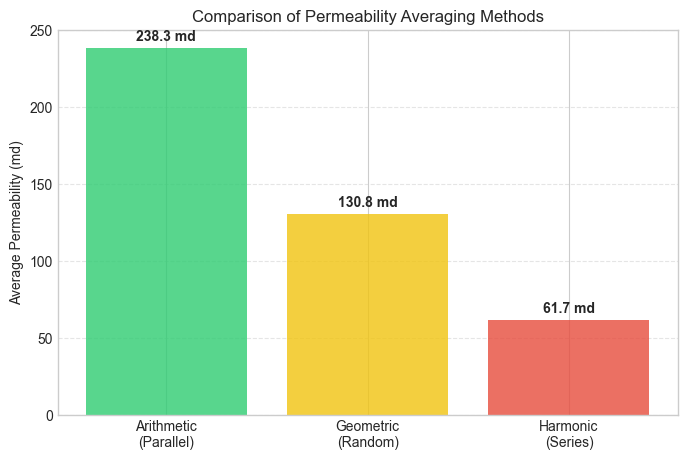

In [3]:
# Visualization of the Averages
averages = [k_avg_arith, k_avg_geo, k_avg_harm]
labels = ['Arithmetic\n(Parallel)', 'Geometric\n(Random)', 'Harmonic\n(Series)']
colors = ['#2ecc71', '#f1c40f', '#e74c3c']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, averages, color=colors, alpha=0.8)

# Add value labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval:.1f} md', ha='center', fontweight='bold')

plt.ylabel('Average Permeability (md)')
plt.title('Comparison of Permeability Averaging Methods')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## 3. Average Porosity ($\bar{\phi}$)

Unlike permeability, porosity is a scalar property (it has magnitude but no direction). Therefore, we almost always use the **Arithmetic Thickness-Weighted Average**.

$$\bar{\phi} = \frac{\sum_{i=1}^{n} \phi_i h_i}{\sum_{i=1}^{n} h_i}$$

*Note: This represents the average storage capacity of the reservoir.*

--- Reservoir Porosity ---
Weighted Average Porosity: 0.2000 (or 20.0%)


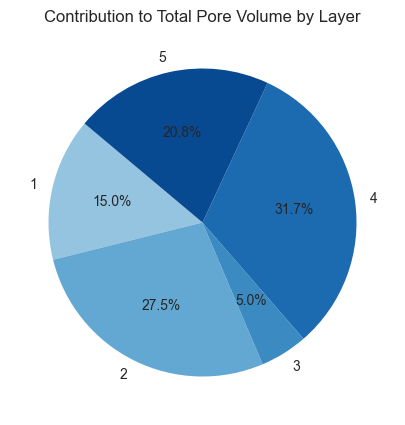

In [4]:
def calc_weighted_porosity(phi_array, h_array):
    """
    Calculates Thickness-Weighted Average Porosity.
    """
    numerator = np.sum(phi_array * h_array)
    denominator = np.sum(h_array)
    return numerator / denominator

# --- CALCULATE ---
phi_vals = df['Porosity_phi'].values
phi_avg = calc_weighted_porosity(phi_vals, h_vals)

print(f"--- Reservoir Porosity ---")
print(f"Weighted Average Porosity: {phi_avg:.4f} (or {phi_avg*100:.1f}%)")

# Visualize the Layer Contributions (Pore Volume per Layer)
# Pore Volume Index ~ phi * h
pore_vol_index = phi_vals * h_vals

plt.figure(figsize=(8, 5))
plt.pie(pore_vol_index, labels=df['Layer'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Blues(np.linspace(0.4, 0.9, 5)))
plt.title('Contribution to Total Pore Volume by Layer')
plt.show()

## Conclusion

In this exercise, we processed core data to find equivalent reservoir properties.

**Key Takeaways:**
1.  **Context Matters:** You cannot simply "average" permeability. You must know the flow direction.
    * For a standard vertical well producing from multiple layers, use **Arithmetic Avg**.
    * For vertical flow (e.g., coning calculations), use **Harmonic Avg**.
2.  **Porosity:** Is simply a volume-weighted average.
3.  **Magnitude:** Arithmetic Average is always the largest; Harmonic is always the smallest.
    $$k_{arith} \geq k_{geo} \geq k_{harm}$$